# AB_FIT_ALL


We actually fit both simulated and real  light curves here !@ 

Here I want to fit the simulated light curves, sampled at timestamps corresponding to combined light curves,  i.e.  SDSS(r), SDSS(r)+PS1(gri), etc.  

We make sure that to each simulated light curve we add the Gaussian noise corresponding to each epochal photometric uncertainty  ( so that the noise matches the claimed error).

Otherwise, if I were only to simulate a perfect DRW signal, and say that there is some photometric uncertainty and yet not add any noise, this would confuse the fitting code about what is the source of variability  - it would be deceived into thinkinig that the errors contribute more to the observed variability than they do (if no noise is added, the errors do not contribute at all, which is not what really happens). 

In reality, a perfect DRW signal is on top of the variability originating from photometric noise, described by the photometric uncertainty (error). Even a constant signal would have some variability due to the photometric uncertainty, which is different for each point (magnitude dependent, etc. )



In [3]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd 
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import unique
from astropy.table import  hstack
from astropy.table import  vstack
from astropy.table import Column
from astropy.table import join
import celerite
import modules as mod
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18


## Simulated : illustrate what's going on ...

In [23]:
lc_sim

mjd,magtrue,magobs,magerr,originBand,originSurvey
float64,float64,float64,float64,str1,str4
51464.21306,20.178451538085938,20.14485619412411,0.023,r,sdss
52197.238825,20.12790870666504,20.117893797268177,0.023,r,sdss
52231.124775,20.123239517211914,20.063092924591096,0.022,r,sdss
52557.23278,20.139745712280273,20.11353016721872,0.028,r,sdss
52578.128858,20.215543746948242,20.22256878751686,0.022,r,sdss
52929.159084,20.0335636138916,20.02666656519204,0.019,r,sdss
52934.13924,20.0600643157959,20.05880470861941,0.022,r,sdss
52936.135167,20.0476016998291,20.052209630250033,0.017,r,sdss
53243.320376,20.128324508666992,20.122075747626837,0.026,r,sdss


1441903.txt
['crts' 'ps1' 'ptf' 'sdss']
472
241


Text(0.1, 0.8, 'Sim LC')

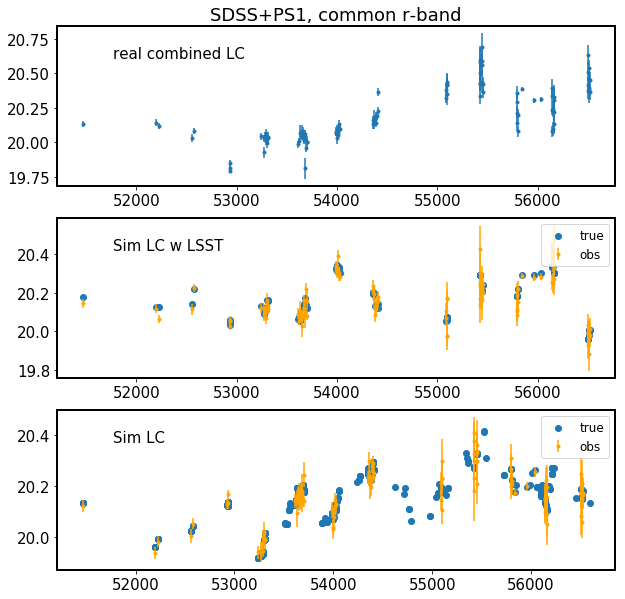

In [4]:



%matplotlib inline

fig,ax  = plt.subplots(3,1,figsize=(10,10))    
offset = 4
realDir = '../data_products/Combined_LC/'
lcs=  os.listdir(realDir)
lc_comb = Table.read(realDir+lcs[0], format='ascii')
print(lcs[0])
print(np.unique(lc_comb['originSurvey'].data))

ax[0].set_title('SDSS+PS1, common r-band')

m = (lc_comb['originSurvey'] == 'sdss') | (lc_comb['originSurvey'] == 'ps1') 
ax[0].errorbar(lc_comb['mjd'][m], lc_comb['mag'][m], lc_comb['magerr'][m], 
           fmt=".", capsize=0)
ax[0].text(0.1,0.8, 'real combined LC', transform=ax[0].transAxes,
          fontsize=15)

simDir = '../data_products/Simulated_LC_w_LSST/'
lc_sim = Table.read(simDir+lcs[0], format='ascii')
m = (lc_sim['originSurvey'] == 'sdss') | (lc_sim['originSurvey'] == 'ps1') 
ax[1].scatter(lc_sim['mjd'][m], lc_sim['magtrue'][m], label='true')
ax[1].errorbar(lc_sim['mjd'][m], lc_sim['magobs'][m], lc_sim['magerr'][m], 
           fmt=".", capsize=0, color='orange', label='obs')
ax[1].text(0.1,0.8, 'Sim LC w LSST', transform=ax[1].transAxes,
          fontsize=15)
ax[1].legend(fontsize=12, loc='upper right')

simDir2 = '../data_products/Simulated_LC_DRW_true/'
lc_sim2 = Table.read(simDir2+lcs[0], format='ascii')
ax[2].scatter(lc_sim2['mjd'], lc_sim2['mag'], label='true')
print(len(lc_sim2))
simDir3 = '../data_products/Simulated_LC_DRW_obs/'
lc_sim3 = Table.read(simDir3+lcs[0], format='ascii')
m = (lc_sim3['survey'] == 'sdss') | (lc_sim3['survey'] == 'ps1') 
ax[2].errorbar(lc_sim3['mjd'][m], lc_sim3['mag'][m], lc_sim3['magerr'][m], 
          fmt=".", capsize=0, color='orange', label='obs')
print(len(lc_sim3))
ax[2].legend(fontsize=12)
ax[2].text(0.1,0.8, 'Sim LC', transform=ax[2].transAxes,
          fontsize=15)

4023205.txt
['crts' 'ps1' 'ptf' 'sdss']


Text(0, 0.5, 'Flux [mag]')

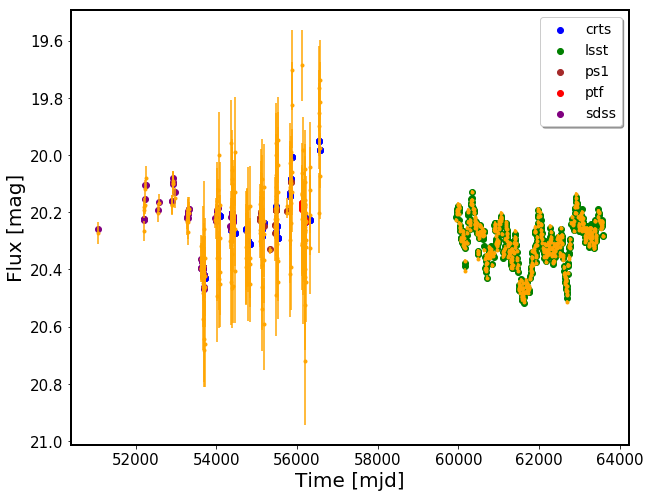

In [33]:
# Illustrate just the errors ...
fig,ax  = plt.subplots(1,1,figsize=(10,8))    

realDir = '../data_products/Combined_LC/'
lcs=  os.listdir(realDir)
choice = 10
lc_comb = Table.read(realDir+lcs[choice], format='ascii')
print(lcs[choice])
print(np.unique(lc_comb['originSurvey'].data))

simDir = '../data_products/Simulated_LC_w_LSST/'
lc_sim = Table.read(simDir+lcs[choice], format='ascii')
colors= ['blue','green', 'brown',  'red', 'purple']
ax_legend_handles =  []
i=0
lw=2
for survey in np.unique(lc_sim['originSurvey']):
    m = lc_sim['originSurvey'] == survey
    # plot true DRW 
    ax.scatter(lc_sim['mjd'][m], lc_sim['magtrue'][m], label=survey, color=colors[i])
    # plot observed DRW 
    ax.errorbar(lc_sim['mjd'][m], lc_sim['magobs'][m], lc_sim['magerr'][m], 
               fmt=".", capsize=0, color='orange', label='')
    #line = mlines.Line2D([], [],  color=colors[i], label=survey.upper(),lw=lw)
    #ax_legend_handles.append(line)
    i += 1 
ax.invert_yaxis()
ax.legend(loc='upper right', 
             bbox_to_anchor=(1.0, 1.0),
             ncol=1, fancybox=True, shadow=True, fontsize=14 ) 
ax.set_xlabel('Time [mjd]')
ax.set_ylabel('Flux [mag]')
#ax[1].text(0.1,08, 'Sim LC w LSST', transform=ax[1].transAxes,
#          fontsize=15)
#ax[1].legend(fontsize=12, loc='upper right')

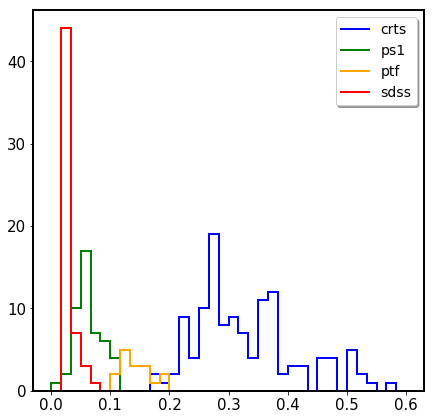

In [21]:
import matplotlib.lines as mlines
fig,ax = plt.subplots(1,1,figsize=(7,7))
colors= ['blue','green', 'orange',  'red']
ax_legend_handles =  []
lw = 2 
i = 0 
for s in np.unique(lc_sim3['survey']):
    m = lc_sim3['survey'] == s
    bins = np.linspace(0,0.6,37)
    ax.hist(lc_sim3['magerr'][m], histtype='step', color=colors[i], lw=lw,
           bins=bins)
    line = mlines.Line2D([], [],  color=colors[i], label=s,lw=lw)
    ax_legend_handles.append(line)
    i += 1 
ax.legend(loc='upper right', handles = ax_legend_handles,
             bbox_to_anchor=(1.0, 1.0),
             ncol=1, fancybox=True, shadow=True, fontsize=14 ) 
ax.set_xlabel('mean error distribution')

Errors distribution in combined light curves : CRTS and PTF are far worse than SDSS and PS1 and thus do not improve the fits as much - way too much noise.

## Fit simulated:  SDSS+PS1+LSST (since there's no real LSST yet...). Original errors. 

In [ ]:
# Fit all combined LCs  with Celerite ...
date = '190306' # '181205'   # 
prior = 'Jeff1'   #  'Jeff1' 

# Input parameters for fitting ... 
SF_inf = 0.2  # mags 
sigma_in = SF_inf / np.sqrt(2)
tau_in = 575 # days 

# simulated light curves , 
# including the true signal, as well as 
# signal with added Gaussian noise
# each realization is sampled at cadences 
# corresponding to real SDSS r,  PTFgR, PS1gri , CRTS V epochs,
# as well as added LSST epochs 
simDir = '../data_products/Simulated_LC_w_LSST/'
lightcurve_list =  os.listdir(simDir)

# define the storage dictionary .... 
results = {}
segments  = ['sdss', 'sdss-ps1', 'sdss-ps1-lsst']
             #'sdss-ps1-ptf-crts','sdss-ps1-ptf-crts-lsst', 
            

for segment in segments : 
    results[segment]  = { 'lcname':[], 'sigmaMAP':[], 'sigmaEXP':[], 
                          'tauMAP':[], 'tauEXP':[],
                          'length':[] }
    
for i in range(len(lightcurve_list)):
    print(i)
    lcname = lightcurve_list[i]
    
    # read in  the observed LC : already done the steps above earlier 
    lc_obs = Table.read(simDir + lcname , format='ascii')
    
    # fit the simulated observation 
    # take segments of each light curve ... 
    for segment in segments : 
        lc = lc_obs[np.in1d(lc_obs['originSurvey'], segment.split(sep='-'))]
        #print(results[sim][segment])
        fit_with_celerite(lc, lcname , results[segment] , prior)
    
    # store the fit 
    if i % 1000 == 0 : 
        # store the intermittent results : up to i-th file, 
        # for this combination of {survey, error} in a file ..
        fname = date + '_Celerite_sim_w_LSST_'+prior+'_'+str(i)+'.npy'
        print('Saved intermittent results up to i=',i, ' as ', fname)
        np.save(fname, results)
        
# store the final thing...
fname = date + '_Celerite_sim_w_LSST_'+prior+'.npy'
print('Saved final Celerite results  to ', fname)
np.save(fname, results)

   




### Fit simulation and real DRW using segments and whole, store the results (as above , but splitting light curves into segments: SDSS, SDSS+PS1,  SDSS+PS1+PTF,  etc. )  

Similar as ** AB_simulate_combined_LCs** , but I use the combined light curves ( consisting of SDSS(r),  and SDSS_synthetic(r),  derived from CRTS(V),  PTF(gR),  PS1(gri), via SDSS(g-i) color ) . 

The simulated DRW (that was all simulated with identical input timescale and amplitude, and sampled at real MJDs of SDSS(ugriz), PTF(gR), PS1(grizy), CRTS(V) ) is sampled at time stamps corresponding to the combined light curves. The errors correspond to real photometric errors at each time stamp ; the appropriate Gaussian noise was added to the simulated DRW signal. 

We fit either points from SDSS(r),   SDSS(r) + SDSS(r, from PTF(gR)) : sections of the light curve that eventually use the entire light curve. In that way we show how adding more data improves the fit. 

Even using all data is biased low : this is expected based on Fig.2 in Kozlowski+2017, that we independently confirmed for Celerite (both MAP and EXP, but EXP less biased). 

For each light curve we note the length of the considered segment  - related to the fitted (or input) timescale it tells us the 'fidelity' of that fit .  (  if rho = input_timescale / baseline < 10 ,  then probably the fit is unbiased,  but if it is above 10, then probably it is ...  ( corresponding to the Fig.2 : the general features are unchanged regardless of number of points (whether SDSS with N=60 pts, or OGLE with N=445 points ... ). The combined light curves fall somewhere in between -  so Fig.2 is a good diagnostic. 

To be perfect,  one would make an equivalent of Fig.2 for each light curve ( given the particular combination of (Npoints, errors, baseline), simulate a range of timescales so that rho between 0.01 to 100 is sampled,  at each rho do 1000 realizations of the same DRW..., and make Fig.2 for that light curve)  this would allow the most accurate estimate of the fit accuracy (vertical spread in Fig.2 at x = fitted rho ) , and bias (offset from y=x on Fig.2) .  

In [6]:
def fit_with_celerite(lc, lcname, dic, prior='Jeff1'): 
    # fit the observed simulated LC and real LC 
    # with Celerite MAP and Expectation value ...
    
    # set limits for grid, MAP , and prior 
    sig_lims , tau_lims = [0.02,0.7], [1,5000]

    # find the Celerite expectation value and MAP 
    # find the MAP estimate 
    sigmaMAP, tauMAP,gp = mod.find_celerite_MAP(lc['mjd'],lc['mag'],
                              lc['magerr'], 
                              sigma_in, tau_in, prior=prior,set_bounds=True, 
                              sig_lims=sig_lims, tau_lims=tau_lims ,verbose=False)
    # expectation from grid  
    Ngrid = 60  ; scale = 'log'
    sigma_grid, tau_grid = mod.make_grid(scale,sig_lims, tau_lims,Ngrid) 
    logP = mod.evaluate_logP(sigma_grid, tau_grid, lc['mag'], gp, prior,
                            'celerite')

    # find the expectation value 
    sigmaEXP, tauEXP = mod.find_expectation_value(logP, sigma_grid, 
                            tau_grid)

    # store the results 
    dic['sigmaMAP'].append(sigmaMAP)
    dic['sigmaEXP'].append(sigmaEXP)
    dic['tauMAP'].append(tauMAP)
    dic['tauEXP'].append(tauEXP)
    dic['lcname'].append(lcname)
    dic['length'].append(max(lc['mjd']) - min(lc['mjd']))

In [3]:
# Fit all combined LCs  with Celerite ...
date = '190228'#   '190224' #   '181128'   # '181127
prior = 'Jeff1' #   'Jeff1' 

# Starting parameters for fitting ... 
SF_inf = 0.2  # mag
sigma_in = SF_inf / np.sqrt(2)  # mag 
tau_in = 575 # days 

# simulated light curves , stored at  mjd corresponding to real light curves 
# simTrueDir = '../data_products/Simulated_LC_DRW_true/'

# simulated light curves sampled at the cadence of combined light curves, 
# with added Gaussian noise corresponding to the quoted 
# photometric uncertainty 
simDir = '../data_products/Simulated_LC_DRW_obs/'

# combined real light curves 
realDir = '../data_products/Combined_LC/'

lightcurve_list =  os.listdir(realDir)

# define the storage dictionary .... 
results = {}
segments  = ['sdss', 'sdss-ps1']#, 'sdss-ps1-ptf', 'sdss-ps1-ptf-crts']
#sims = ['real', 'simulated']
sim = 'real'
for segment in segments :
    results[segment]  = { 'lcname':[], 'sigmaMAP':[], 'sigmaEXP':[], 
                                   'tauMAP':[], 'tauEXP':[],
                                  'length':[]  }
#for sim in sims : 
#    results[sim] = {}
#    for segment in segments : 
#        results[sim][segment]  = { 'lcname':[], 'sigmaMAP':[], 'sigmaEXP':[], 
#                                   'tauMAP':[], 'tauEXP':[],
#                                  'length':[]
#                                 }


Check if all light curves are the same length ... 

In [35]:
prior = 'Jeff1'
l1 = []
l2 = []
for i in range(len(lightcurve_list)):

    # read in the real light curve 
    lcname = lightcurve_list[i]
    lc_real = Table.read(realDir+lcname, format='ascii')
    lc_real.sort('mjd')

    # keep only the first row if there are two that 
    # have the same MJD ...
    lc_real = unique(lc_real, keys='mjd', keep='first')
    lc_real.rename_column('originSurvey', 'survey')
    
    lc_sim = Table.read(simDir + lcname , format='ascii')
    
    l1.append(len(lc_real))
    l2.append(len(lc_sim))
    
t = Table([lightcurve_list, l1,l2],)
# The only light curves that have different lenght 
# between real combined and simulated observed ...
# I don't know why,  can figure that out later ... 
t[ (t['col1'] - t['col2']) < 0]

Run the fitting with real and simulated light curves ... 
Use Jeff1 which is the best solution for EXP. 

In [7]:
prior = 'Jeff1'
for i in range(len(lightcurve_list)):
    
    if i % 10  == 0  :  print('\r',i)
        
    # read in the real light curve 
    lcname = lightcurve_list[i]
    lc_real = Table.read(realDir+lcname, format='ascii')
    lc_real.sort('mjd')

    # keep only the first row if there are two that 
    # have the same MJD ...
    lc_real = unique(lc_real, keys='mjd', keep='first')
    lc_real.rename_column('originSurvey', 'survey')

    # read in  the observed version of the simulated LC:
    # this is the simulated LC with Gaussian offset corresponding
    # to cited errors - heteroscedastic,  since there are 
    # each different ... corresponding to SDSS or PS1 
    # sampled at the same epochs as the real light
    # curve. Thus it  should have 
    # identical number of rows as the real combined LC  above ... 
    #lc_sim = Table.read(simDir + lcname , format='ascii')
    
    #################
    #     Fit       #
    #################
    # Take simulated, then the real light curve 
    #for lcs , sim in zip( [lc_real, lc_sim] , sims) :
    lcs = lc_real
    sim  = 'real'
    # take segments of each light curve ... 
    for segment in segments : 
        lc = lcs[np.in1d(lcs['survey'], segment.split(sep='-'))]
        fit_with_celerite(lc, lcname , results[segment] , prior)
    
    # store the fit 
    if i % 1000 == 0 : 
        # store the intermittent results : up to i-th file, 
        # for this combination of {survey, error} in a file ..
        fname = date + '_Celerite_real_'+prior+'_'+str(i)+'.npy'
        print('Saved intermittent results up to i=',i, ' as ', fname)
        np.save(fname, results)
        
# store the final thing...
fname = date + '_Celerite_real_'+prior+'.npy'
print('Saved final Celerite results  to ', fname)
np.save(fname, results)

   

 0
Saved intermittent results up to i= 0  as  190228_Celerite_real_Jeff1_0.npy
 10
 20
 30
 40


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:361: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:366: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


 50
 60
 70
 80
 90
 100
 110
 120
 130
 140
 150
 160
 170
 180
 190
 200
 210
 220
 230
 240
 250
 260
 270
 280
 290
 300
 310
 320
 330


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:361: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:366: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


 340
 350
 360
 370
 380
 390
 400
 410
 420
 430
 440
 450
 460
 470
 480
 490
 500
 510
 520
 530
 540
 550
 560
 570
 580
 590
 600
 610
 620
 630
 640
 650
 660
 670
 680
 690
 700
 710
 720
 730
 740
 750


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:361: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:366: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


 760
 770
 780
 790
 800
 810
 820
 830
 840
 850
 860
 870
 880
 890
 900
 910
 920
 930
 940
 950
 960
 970
 980
 990
 1000
Saved intermittent results up to i= 1000  as  190228_Celerite_real_Jeff1_1000.npy
 1010
 1020
 1030
 1040
 1050
 1060
 1070
 1080
 1090


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:361: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:366: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


 1100
 1110
 1120
 1130
 1140
 1150
 1160
 1170
 1180
 1190
 1200
 1210
 1220
 1230
 1240
 1250
 1260
 1270
 1280
 1290
 1300
 1310
 1320
 1330
 1340
 1350
 1360
 1370
 1380
 1390
 1400
 1410
 1420
 1430
 1440
 1450
 1460
 1470
 1480
 1490
 1500
 1510
 1520
 1530
 1540
 1550
 1560
 1570
 1580
 1590
 1600
 1610
 1620


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:361: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:366: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


 1630
 1640
 1650
 1660
 1670
 1680
 1690
 1700
 1710
 1720
 1730
 1740
 1750
 1760
 1770
 1780
 1790
 1800
 1810
 1820
 1830
 1840
 1850
 1860
 1870
 1880
 1890
 1900
 1910
 1920
 1930
 1940
 1950
 1960
 1970
 1980
 1990
 2000
Saved intermittent results up to i= 2000  as  190228_Celerite_real_Jeff1_2000.npy
 2010
 2020
 2030
 2040
 2050
 2060
 2070
 2080
 2090
 2100
 2110
 2120
 2130
 2140
 2150
 2160
 2170
 2180


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:361: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:366: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


 2190
 2200
 2210
 2220
 2230
 2240
 2250
 2260
 2270
 2280
 2290
 2300
 2310
 2320
 2330
 2340
 2350
 2360
 2370
 2380
 2390
 2400
 2410
 2420
 2430
 2440
 2450
 2460
 2470
 2480
 2490
 2500
 2510
 2520
 2530
 2540
 2550
 2560
 2570
 2580
 2590
 2600
 2610
 2620
 2630
 2640
 2650
 2660
 2670
 2680
 2690
 2700
 2710
 2720
 2730
 2740
 2750
 2760
 2770
 2780
 2790
 2800
 2810
 2820
 2830
 2840
 2850
 2860
 2870
 2880
 2890
 2900
 2910
 2920
 2930
 2940
 2950
 2960
 2970
 2980
 2990
 3000
Saved intermittent results up to i= 3000  as  190228_Celerite_real_Jeff1_3000.npy
 3010
 3020
 3030
 3040
 3050
 3060
 3070
 3080
 3090
 3100
 3110
 3120
 3130
 3140
 3150
 3160
 3170
 3180
 3190
 3200
 3210
 3220
 3230
 3240
 3250
 3260
 3270
 3280
 3290
 3300
 3310
 3320
 3330
 3340
 3350
 3360
 3370
 3380
 3390
 3400
 3410
 3420
 3430
 3440
 3450
 3460
 3470
 3480
 3490
 3500
 3510
 3520
 3530
 3540
 3550
 3560
 3570
 3580
 3590
 3600
 3610
 3620
 3630
 3640
 3650
 3660
 3670
 3680
 3690
 3700
 3710


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:361: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:366: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


 3770
 3780
 3790
 3800
 3810
 3820
 3830
 3840
 3850
 3860
 3870
 3880
 3890
 3900
 3910
 3920
 3930
 3940
 3950
 3960
 3970
 3980
 3990
 4000
Saved intermittent results up to i= 4000  as  190228_Celerite_real_Jeff1_4000.npy
 4010
 4020
 4030
 4040
 4050
 4060
 4070
 4080
 4090
 4100
 4110
 4120
 4130
 4140
 4150
 4160
 4170
 4180
 4190
 4200
 4210
 4220
 4230
 4240
 4250
 4260
 4270
 4280


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:361: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:366: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


 4290
 4300
 4310
 4320
 4330
 4340
 4350
 4360
 4370
 4380
 4390
 4400
 4410
 4420
 4430
 4440
 4450
 4460
 4470
 4480
 4490
 4500
 4510
 4520
 4530
 4540
 4550


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:361: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:366: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


 4560
 4570
 4580
 4590
 4600
 4610
 4620
 4630
 4640
 4650
 4660
 4670
 4680
 4690
 4700
 4710
 4720
 4730
 4740
 4750
 4760
 4770
 4780
 4790
 4800
 4810
 4820
 4830
 4840
 4850
 4860
 4870
 4880
 4890
 4900
 4910
 4920
 4930


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:361: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:366: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


 4940
 4950
 4960
 4970
 4980
 4990
 5000
Saved intermittent results up to i= 5000  as  190228_Celerite_real_Jeff1_5000.npy
 5010
 5020
 5030
 5040


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:361: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:366: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


 5050
 5060
 5070
 5080
 5090
 5100
 5110
 5120
 5130
 5140
 5150
 5160
 5170
 5180
 5190
 5200
 5210
 5220
 5230
 5240
 5250
 5260
 5270
 5280
 5290
 5300
 5310
 5320
 5330
 5340
 5350
 5360
 5370
 5380
 5390
 5400
 5410
 5420
 5430
 5440
 5450
 5460
 5470
 5480
 5490
 5500
 5510
 5520
 5530
 5540
 5550
 5560
 5570
 5580
 5590
 5600
 5610
 5620
 5630
 5640
 5650
 5660
 5670
 5680
 5690
 5700
 5710
 5720
 5730
 5740
 5750
 5760


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:361: RuntimeWarning: invalid value encountered in subtract
  logP -= logP.max()
/Users/chris/GradResearch/Paper2_SDSS_PTF_PS1/code/modules.py:366: RuntimeWarning: invalid value encountered in less
  logP[logP < -10] = -10  # set the minimum for plotting


 5770
 5780
 5790
 5800
 5810
 5820
 5830
 5840
 5850
 5860
 5870
 5880
 5890
 5900
 5910
 5920
 5930
 5940
 5950
 5960
 5970
 5980
 5990
 6000
Saved intermittent results up to i= 6000  as  190228_Celerite_real_Jeff1_6000.npy
 6010
 6020
 6030
 6040
 6050
 6060
 6070
 6080
 6090
 6100
 6110
 6120
 6130
 6140
 6150
 6160
 6170
 6180
 6190
 6200
 6210
 6220
 6230
 6240
 6250
 6260
 6270
 6280
 6290
 6300
 6310
 6320
 6330
 6340
 6350
 6360
 6370
 6380
 6390
 6400
 6410
 6420
 6430
 6440
Saved final Celerite results  to  190228_Celerite_real_Jeff1.npy
